##XGBoost

In [37]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Forcasting based on Energy Charts datasets/Energy_Charts_2025_January_to_June.csv"



# Load the dataset
#df = pd.read_csv(path, low_memory=False)
#df = df.fillna(0)
#df = df.loc[df['Date (GMT+1)'].notna()]

# Feature selection
#Residual load
#Fossil brown coal / lignite
#Renewable share of load
#Renewable share of generation

drop_cols = [
"Hydro pumped storage consumption",
"Cross border electricity trading",
"Nuclear",
"Hydro Run-of-River",
"Biomass",
"Fossil hard coal",
"Fossil oil",
"Fossil coal-derived gas",
"Fossil gas",
"Geothermal",
"Hydro water reservoir",
"Hydro pumped storage",
"Others",
"Waste",
"Wind offshore",
"Wind onshore",
"Solar",
"Load",
]

df = (
    pd.read_csv(path, low_memory=False)
      .fillna(0)
      .query("`Date (GMT+1)` == `Date (GMT+1)`")  # filter notna()
      .drop(columns=drop_cols)
)
df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
df = df.set_index(['Date (GMT+1)'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-2136390693.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
/tmp/ipython-input-2136390693.py:49: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)


In [38]:
features = [
    'Residual load',
    'Fossil brown coal / lignite',
    'Renewable share of load',
    'Renewable share of generation'
]

In [39]:
# Applying the default XGBoost model

# Create objects X and y
X = df[features]
y = df['Day Ahead Auction (DE-LU)']

# Create Train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=12345, shuffle=False)

from xgboost import XGBRegressor
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

xgb_fcst = my_xgb.predict(X_test)

# Metrics
r2 = r2_score(y_test, xgb_fcst)
mse = mean_squared_error(y_test, xgb_fcst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, xgb_fcst)
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))

R²: 0.5013734497112438
MSE: 1829.0048996870385
RMSE: 42.76686684440466
MAE: 25.30471207349301
0.5013734497112438


##LIGHTGBM

In [40]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

lgbm_fcst = my_lgbm.predict(X_test)

# Metrics
r2 = r2_score(y_test, lgbm_fcst)
mse = mean_squared_error(y_test, lgbm_fcst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lgbm_fcst)
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

print(r2_score(list(y_test), list(lgbm_fcst)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 17272, number of used features: 4
[LightGBM] [Info] Start training from score 90.642723
R²: 0.5513990146782064
MSE: 1645.5068421102796
RMSE: 40.5648473694932
MAE: 24.511548922252477
0.5513990146782064


##XGBoost and LightGBM

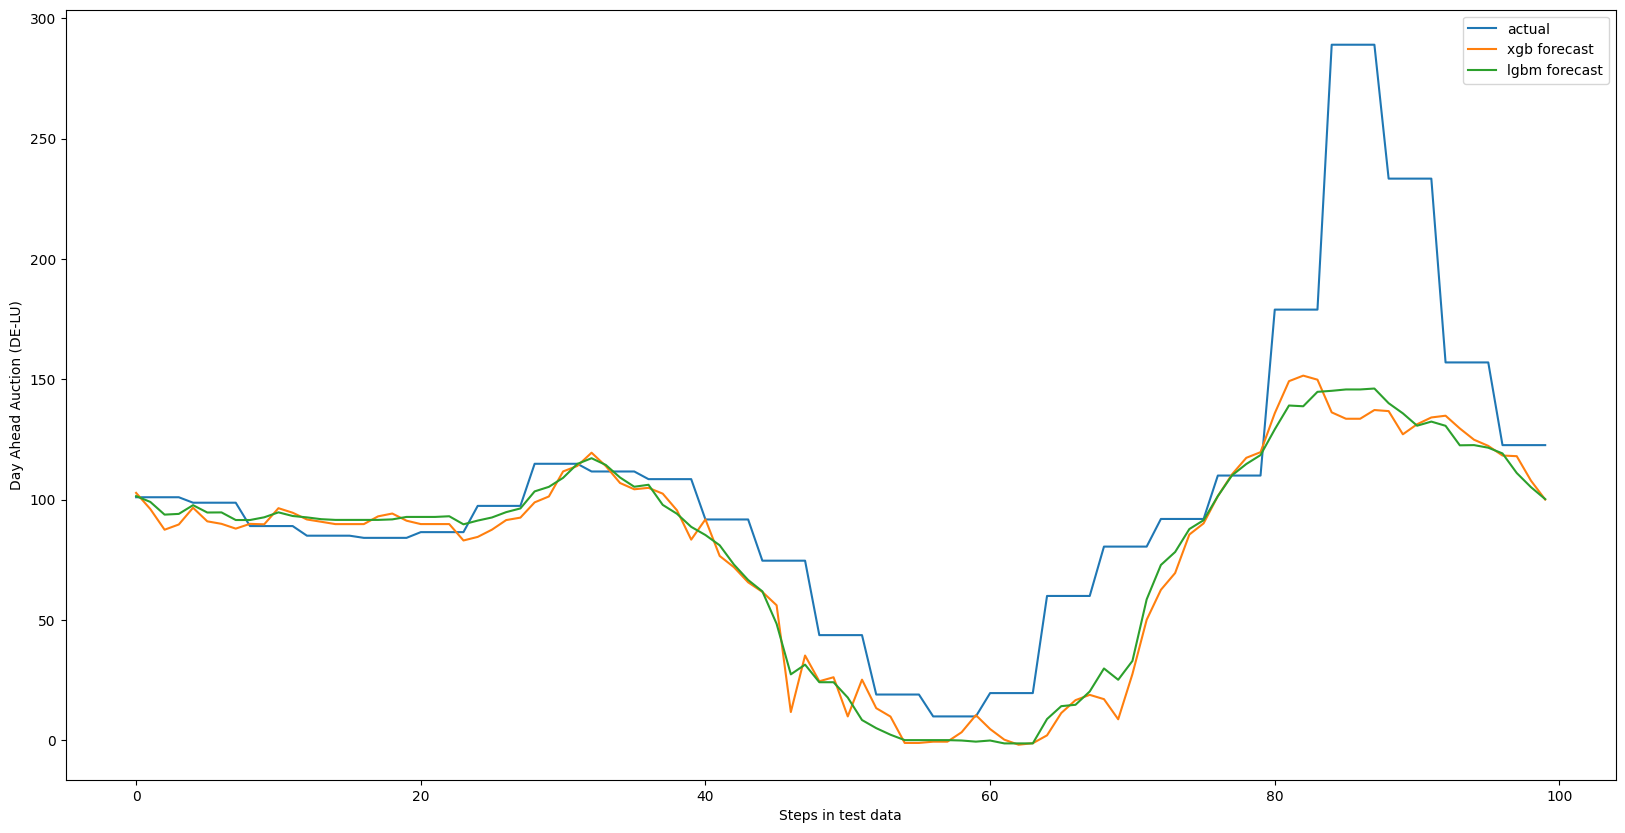

In [41]:
# Create a graph to compare the XGBoost and LightGBM forecast to the actuals

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Day Ahead Auction (DE-LU)')
plt.xlabel('Steps in test data')
plt.show()

# Evaluation

##XGBoost  
R²: 0.5013734497112438  
MSE: 1829.0048996870385  
RMSE: 42.76686684440466  
MAE: 25.30471207349301    

##LightGBM  
R²: 0.5513990146782064  
MSE: 1645.5068421102796  
RMSE: 40.5648473694932  
MAE: 24.511548922252477  

##Baseline model
R²: 0.6272404679277302  
MSE: 1424.2550828672138  
MSAE: 1903296216.2467513  
RMSE: 37.7393042181121  

XGBoost and LightGBM run much faster